In [ ]:
import json
from PIL import Image
import os
from tqdm import tqdm
from torchvision import transforms
import torch

# COCO data
coco_annotations_path = '/Users/minli/Desktop/dl_project/annotations/captions_train2017.json'
coco_images_path = "/Users/minli/Desktop/dl_project/train2017/"
output_data_path = '/Users/minli/Desktop/dl_project/processed_data/'

# output folder
if not os.path.exists(output_data_path):
    os.makedirs(output_data_path)

# Load COCO
with open(coco_annotations_path, 'r') as f:
    coco_data = json.load(f)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define low-quality sample filtering
def clean_and_process_data(coco_data, images_path, output_path):
    valid_data = []
    annotations = coco_data['annotations']

    # tqdm for progress bar display
    for annotation in tqdm(annotations, desc="Cleaning and processing data", unit="samples"):
        caption = annotation['caption']
        image_id = annotation['image_id']
        image_path = os.path.join(images_path, f"{image_id:012d}.jpg")

        # Check if the image exists and if the quality is acceptable
        if os.path.exists(image_path):
            try:
                img = Image.open(image_path).convert("RGB")
                if img.size[0] < 100 or img.size[1] < 100:
                    continue


                img_tensor = transform(img)


                tensor_path = os.path.join(output_path, f"{image_id:012d}.pt")
                torch.save(img_tensor, tensor_path)


                if 5 < len(caption.split()) < 50:
                    valid_data.append({'image': tensor_path, 'caption': caption})
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

    return valid_data


cleaned_data = clean_and_process_data(coco_data, coco_images_path, output_data_path)

# Save data as JSON
output_file = os.path.join(output_data_path, "cleaned_coco_data.json")
with open(output_file, "w") as f:
    json.dump(cleaned_data, f, indent=4)

print(f"Cleaned and processed data saved to {output_file}.")


In [ ]:
import json
import os


input_json_path = '/Users/minli/Desktop/dl_project/processed_data/cleaned_coco_data.json'


output_json_path = '/Users/minli/Desktop/dl_project/cleaned_coco_data.json'


prefix_to_remove = '/Users/minli/Desktop/dl_project/processed_data/'


with open(input_json_path, 'r') as f:
    augmented_data = json.load(f)


for item in augmented_data:
    if item['image'].startswith(prefix_to_remove):
        item['image'] = item['image'].replace(prefix_to_remove, '')


with open(output_json_path, 'w') as f:
    json.dump(augmented_data, f, indent=4)

print(f"Updated JSON saved to {output_json_path}")


In [ ]:
import random
import shutil
import os
import json


coco_processed_path = "/Users/minli/Desktop/dl_project/processed_data"


cleaned_data_path = os.path.join(coco_processed_path, "cleaned_coco_data.json")


selected_processed_path = "/Users/minli/Desktop/dl_project/selected_processed_data/"


selected_data_json_path = os.path.join(selected_processed_path, "selected_cleaned_coco_data.json")


if not os.path.exists(selected_processed_path):
    os.makedirs(selected_processed_path)


with open(cleaned_data_path, "r") as f:
    cleaned_data = json.load(f)


processed_files = [f for f in os.listdir(coco_processed_path) if f.endswith('.pt')]

# random seed
random.seed(42)

# Randomly select 3000 .pt files
selected_files = random.sample(processed_files, min(3000, len(processed_files)))

# Filter JSON data to match the selected .pt files
selected_cleaned_data = [
    {"image": item["image"], "caption": item["caption"]}
    for item in cleaned_data if item["image"] in selected_files
]

# Copy the selected .pt files to the target folder
for processed_file in selected_files:
    source_path = os.path.join(coco_processed_path, processed_file)
    target_path = os.path.join(selected_processed_path, processed_file)
    try:
        shutil.copy(source_path, target_path)
    except Exception as e:
        print(f"Error copying {source_path}: {e}")

# Save the filtered JSON data
with open(selected_data_json_path, "w") as f:
    json.dump(selected_cleaned_data, f, indent=4)

print(f"Randomly selected 3000 processed files saved to {selected_processed_path}.")
print(f"Corresponding JSON data saved to {selected_data_json_path}.")


Randomly selected 3000 processed files saved to /Users/minli/Desktop/dl_project/selected_processed_data/.
Corresponding JSON data saved to /Users/minli/Desktop/dl_project/selected_processed_data/selected_cleaned_coco_data.json.


In [ ]:
import random
import shutil
import os
import json
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm


project_path = '/Users/minli/Desktop/dl_project'


processed_data_path = os.path.join(project_path, "selected_processed_data")
cleaned_data_file = os.path.join(processed_data_path, "selected_cleaned_coco_data.json")


augmented_data_folder = os.path.join(project_path, "Augmented")

# Create the folder
if not os.path.exists(augmented_data_folder):
    os.makedirs(augmented_data_folder)

# Data augmentation pipeline
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(224, 224),
                                 scale=(0.8, 1.0),
                                 ratio=(3/4, 4/3)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Check if the cleaned data file exists
if not os.path.exists(cleaned_data_file):
    raise FileNotFoundError(f"Cleaned data file not found: {cleaned_data_file}")


with open(cleaned_data_file, "r") as f:
    cleaned_data = json.load(f)

# generate augmented data
def generate_augmented_data(cleaned_data, transform, output_folder, augment_per_image=3):
    """
    Generates augmented samples for the cleaned data and saves them to the specified folder.

    Args:
    cleaned_data (list): Cleaned data containing 'image' and 'caption' fields.
    transform (torchvision.transforms.Compose): Data augmentation pipeline.
    output_folder (str): Folder to save the augmented data.
    augment_per_image (int): Number of augmented samples generated per image.
    """
    augmented_data = []

    for data in tqdm(cleaned_data, desc="Generating augmented data"):
        image_path = os.path.join(processed_data_path, data['image'])  # Construct full path
        caption = data['caption']

        try:

            original_tensor = torch.load(image_path)


            original_image = transforms.ToPILImage()(original_tensor)

            for i in range(augment_per_image):

                augmented_image = transform(original_image)


                augmented_image_path = os.path.join(
                    output_folder,
                    f"{os.path.splitext(os.path.basename(image_path))[0]}_aug_{i + 1}.pt"
                )


                torch.save(augmented_image, augmented_image_path)


                augmented_data.append({'image': os.path.basename(augmented_image_path), 'caption': caption})

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    return augmented_data

# Generate augmented data
augmented_data = generate_augmented_data(cleaned_data, data_augmentation, augmented_data_folder, augment_per_image=3)

# record to a JSON file
augmented_data_json_path = os.path.join(augmented_data_folder, "augmented_data.json")
with open(augmented_data_json_path, "w") as f:
    json.dump(augmented_data, f, indent=4)

print(f"Augmented data saved to {augmented_data_folder}.")
print(f"Augmented data JSON file saved to {augmented_data_json_path}.")


Generating augmented data:   0%|                      | 0/15009 [00:00<?, ?it/s]/var/folders/s8/yvv_kdxj0k93qry0tsphc_mc0000gn/T/ipykernel_53421/1867342709.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rela

Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000526089.pt: [Errno 60] Operation timed out


Generating augmented data:  62%|██████▊    | 9341/15009 [24:39<18:56,  4.99it/s]

Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000290415.pt: Ran out of input
Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000290415.pt: Ran out of input
Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000290415.pt: Ran out of input
Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000290415.pt: Ran out of input
Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000290415.pt: Ran out of input


Generating augmented data:  89%|████████▉ | 13367/15009 [37:35<06:05,  4.49it/s]

Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000197934.pt: [Errno 60] Operation timed out


Generating augmented data:  92%|█████████▏| 13779/15009 [39:03<06:49,  3.00it/s]

Error processing /Users/minli/Desktop/dl_project/selected_processed_data/000000389391.pt: [Errno 60] Operation timed out


Generating augmented data: 100%|██████████| 15009/15009 [42:04<00:00,  5.94it/s]


Augmented data saved to /Users/minli/Desktop/dl_project/Augmented.
Augmented data JSON file saved to /Users/minli/Desktop/dl_project/Augmented/augmented_data.json.


Loaded 45003 augmented samples.


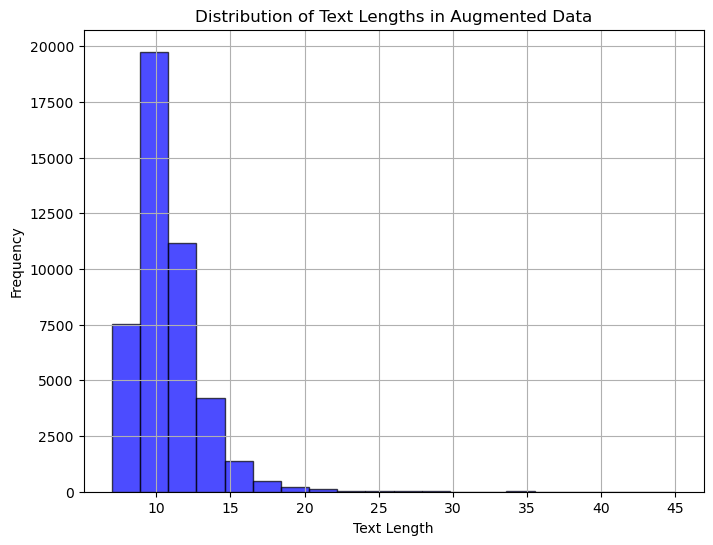

In [ ]:
import matplotlib.pyplot as plt
import os
import json


augmented_data_folder = os.path.join('/Users/minli/Desktop/dl_project', "Augmented")
augmented_data_json_path = os.path.join(augmented_data_folder, "augmented_data.json")


if not os.path.exists(augmented_data_json_path):
    raise FileNotFoundError(f"Augmented data JSON file not found: {augmented_data_json_path}")

with open(augmented_data_json_path, "r") as f:
    augmented_data = json.load(f)

print(f"Loaded {len(augmented_data)} augmented samples.")


text_lengths = [len(data['caption'].split()) for data in augmented_data]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in Augmented Data')
plt.grid(True)
plt.show()



In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

<ipython-input-4-9862e59bf9ed>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path)


Loaded 000000432727.pt shape torch.Size([3, 224, 224])
Caption: A little boy with an orange sweater holding a wii remote.


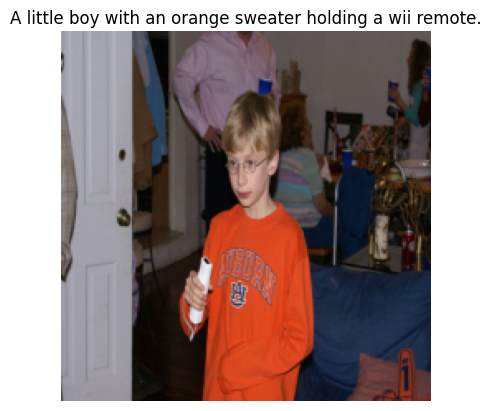

Loaded 000000007517.pt shape torch.Size([3, 224, 224])
Caption:  A BATHROOM WITH A TOILET IN THE BATHROOM 


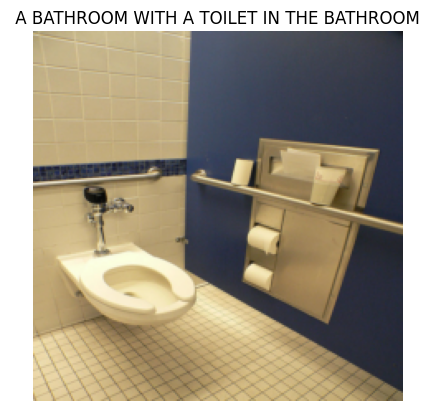

Loaded 000000090287.pt shape torch.Size([3, 224, 224])
Caption: A shot of a skier and a snowboarder going down a large slope.


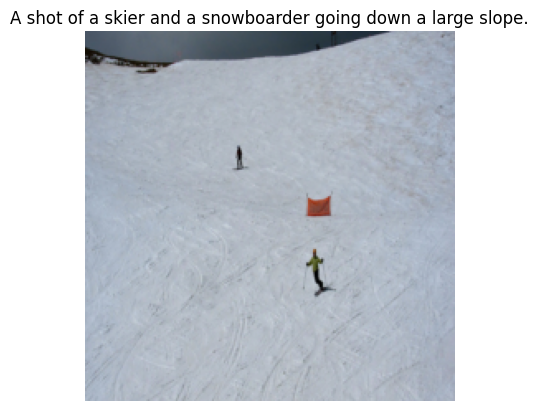

Loaded 000000441449.pt shape torch.Size([3, 224, 224])
Caption: A small bowl of oranges on a table.


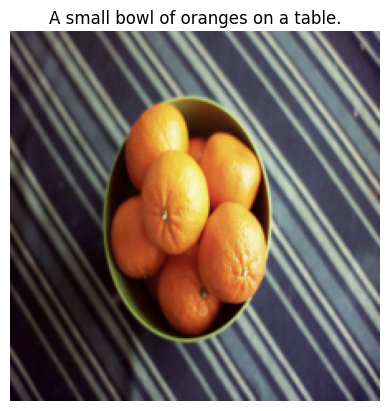

Loaded 000000087387.pt shape torch.Size([3, 224, 224])
Caption: A clock monument in the middle of a city street.


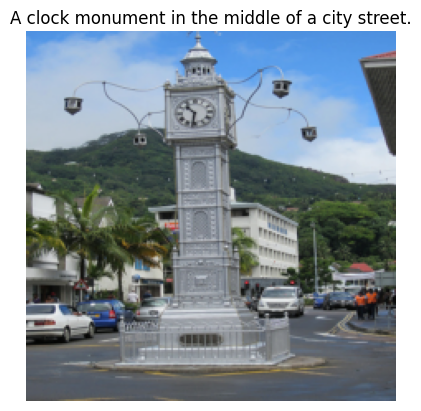

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

selected_data_folder = os.path.join('/content/drive/MyDrive/dl_final_project/', "selected_processed_data")
files = os.listdir(selected_data_folder)
pt_files = [f for f in files if f.endswith('.pt')]

json_file_path = os.path.join('/content/drive/MyDrive/dl_final_project/', "selected_cleaned_coco_data.json")
with open(json_file_path, 'r') as file:
    data = json.load(file)

data_dict = {item['image']: item['caption'] for item in data}

for pt_file in random.choices(pt_files, k=5):
    file_path = os.path.join(selected_data_folder, pt_file)
    try:
        tensor = torch.load(file_path)
        unnormalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
        )

        img_tensor = unnormalize(tensor)
        print("Loaded", pt_file, "shape", tensor.shape)

        if pt_file in data_dict:
            caption = data_dict[pt_file]
            print("Caption:", caption)

            img = transforms.ToPILImage()(img_tensor)
            plt.imshow(img)
            plt.title(caption)
            plt.axis('off')
            plt.show()
        else:
            print("No caption found for", pt_file)

    except Exception as e:
        print("Loading Error:", pt_file, "error", e)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Evaluating baseline model...


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)


Generated: an image of a bird flying in the sky | Ground Truth: A large delta airlines plane flying in the sky.
Generated: a dog is running on the street in the city | Ground Truth: A gentleman riding a horse down a city street.
Generated: an image of a computer screen with multiple colors | Ground Truth: Two female tennis players shaking hands in front of the referee
Generated: an image of a television screen with a red background | Ground Truth: a big bear runs through a wooded area 
Generated: an image of a group of fish swimming in the water | Ground Truth: A person with pizza in hand, and other pizzas on the table.
Generated: an image of a green and red substance | Ground Truth: A man leans against a wall smiling by an amp.
Generated: an image of a circle made out of leaves | Ground Truth: A white plate topped with chicken, broccoli and mushrooms.
Generated: a painting of a rainbow colored swirl | Ground Truth: A row of cars on side of street next to buildings.
Generated: a psyche

<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)


Epoch 2 completed | Loss: 1.3292


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)


Epoch 3 completed | Loss: 1.1252


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)


Epoch 4 completed | Loss: 1.0142


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)


Epoch 5 completed | Loss: 0.9201
Epoch 5 completed | Loss: 0.9201


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 6 completed | Loss: 0.8356
Epoch 6 completed | Loss: 0.8356


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 7 completed | Loss: 0.7551
Epoch 7 completed | Loss: 0.7551


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 8 completed | Loss: 0.6686
Epoch 8 completed | Loss: 0.6686


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 9 completed | Loss: 0.5923
Epoch 9 completed | Loss: 0.5923


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 10 completed | Loss: 0.5275
Epoch 10 completed | Loss: 0.5275


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 11 completed | Loss: 0.4564
Epoch 11 completed | Loss: 0.4564


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 12 completed | Loss: 0.3986
Epoch 12 completed | Loss: 0.3986


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 13 completed | Loss: 0.3446
Epoch 13 completed | Loss: 0.3446


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 14 completed | Loss: 0.3050
Epoch 14 completed | Loss: 0.3050


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Epoch 15 completed | Loss: 0.2714
Epoch 15 completed | Loss: 0.2714
Evaluating fine-tuned model...
Evaluating fine-tuned model...


<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_path)
<ipython-input-5-4a1b2d92d0f7>:41: FutureWarning: You are usi

Fine-Tuned Metrics:
Factual Score: 0.7869
Entity-Level Consistency: 0.8608
Fine-Tuned Metrics:
Factual Score: 0.7869
Entity-Level Consistency: 0.8608
Fine-Tuned Hallucination Rate: 13.92%
Hallucination Rate Reduction: 15.52%
Fine-Tuned Hallucination Rate: 13.92%
Hallucination Rate Reduction: 15.52%
Post-Calibration Metrics:
Factual Score: 0.8665
Entity-Level Consistency: 0.8665
Hallucination Rate: 13.35%
Post-Calibration Metrics:
Factual Score: 0.8665
Entity-Level Consistency: 0.8665
Hallucination Rate: 13.35%


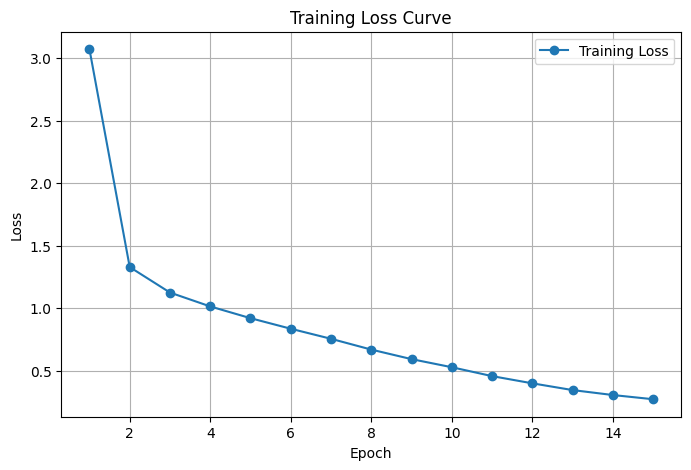

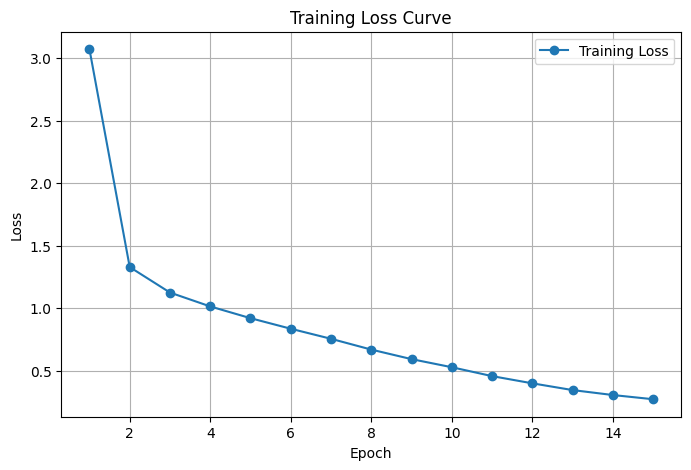

Training, evaluation, and calibration complete.
Training, evaluation, and calibration complete.


In [ ]:
import os
import json
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import precision_score
from nltk.translate.bleu_score import sentence_bleu
import spacy
from sentence_transformers import SentenceTransformer, util

baseline_results_path = "/content/drive/MyDrive/dl_final_project/baseline_results.json"
fine_tuned_results_path = "/content/drive/MyDrive/dl_final_project/fine_tuned_results.json"
calibrated_results_path = "/content/drive/MyDrive/dl_final_project/calibrated_results.json"
saved_model_path = "/content/drive/MyDrive/dl_final_project/saved_model"

nlp = spacy.load("en_core_web_sm")
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

class ImageCaptionDataset(Dataset):
    def __init__(self, data_folder, json_file, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.data_folder = data_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.data_folder, item['image'])
        try:
            image = torch.load(image_path)
        except (EOFError, RuntimeError, pickle.UnpicklingError) as e:
            print(f"Skipping corrupted file: {image_path} | Error: {e}")
            image = torch.zeros((3, 224, 224))
            caption = "Corrupted file skipped"
            return image, caption

        caption = item['caption']
        if self.transform:
            image = self.transform(image)
        return image, caption

def compute_factual_score(generated_captions, reference_captions):
    scores = []
    for gen_caption, ref_caption in zip(generated_captions, reference_captions):
        gen_entities = {ent.text for ent in nlp(gen_caption).ents}
        ref_entities = {ent.text for ent in nlp(ref_caption).ents}
        intersection = len(gen_entities & ref_entities)
        union = len(gen_entities | ref_entities)
        score = intersection / union if union > 0 else 1.0
        scores.append(score)
    return np.mean(scores)

def compute_entity_level_consistency(generated_captions, reference_captions):
    scores = []
    for gen_caption, ref_caption in zip(generated_captions, reference_captions):
        gen_entities = {ent.text for ent in nlp(gen_caption).ents}
        ref_entities = {ent.text for ent in nlp(ref_caption).ents}
        score = len(gen_entities & ref_entities) / len(ref_entities) if ref_entities else 1.0
        scores.append(score)
    return np.mean(scores)

def post_hoc_calibration(generated_captions, reference_captions):
    calibrated_captions = []
    for gen_caption, ref_caption in zip(generated_captions, reference_captions):
        gen_entities = {ent.text for ent in nlp(gen_caption).ents}
        ref_entities = {ent.text for ent in nlp(ref_caption).ents}
        entity_match_score = len(gen_entities & ref_entities) / len(ref_entities) if ref_entities else 1.0

        embeddings_gen = similarity_model.encode(gen_caption, convert_to_tensor=True)
        embeddings_ref = similarity_model.encode(ref_caption, convert_to_tensor=True)
        similarity_score = util.pytorch_cos_sim(embeddings_gen, embeddings_ref).item()

        if entity_match_score < 0.5 or similarity_score < 0.7:
            calibrated_captions.append("Low quality caption detected")
        else:
            calibrated_captions.append(gen_caption)
    return calibrated_captions

def compute_hallucination_rate(generated_captions, reference_captions, threshold=0.5):
    hallucinated_count = 0
    total_count = len(generated_captions)

    for gen_caption, ref_caption in zip(generated_captions, reference_captions):
        gen_entities = {ent.text for ent in nlp(gen_caption).ents}
        ref_entities = {ent.text for ent in nlp(ref_caption).ents}

        entity_consistency = len(gen_entities & ref_entities) / len(ref_entities) if ref_entities else 1.0

        if entity_consistency < threshold:
            hallucinated_count += 1

    hallucination_rate = (hallucinated_count / total_count) * 100
    return hallucination_rate

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageCaptionDataset(
    data_folder='/content/drive/MyDrive/dl_final_project/selected_processed_data',
    json_file='/content/drive/MyDrive/dl_final_project/selected_cleaned_coco_data.json',
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.to(device)

# Baseline Evaluation
model.eval()
baseline_results = []

print("Evaluating baseline model...")
for batch_idx, (images, captions) in enumerate(dataloader):
    if batch_idx > 10:
        break
    images = [transforms.ToPILImage()(img.cpu()) for img in images]
    inputs = processor(images=images, text=None, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=50, num_beams=5)
    generated_captions = processor.batch_decode(outputs, skip_special_tokens=True)
    for i, caption in enumerate(generated_captions):
        baseline_results.append({"generated": caption, "ground_truth": captions[i]})
        print(f"Generated: {caption} | Ground Truth: {captions[i]}")


with open(baseline_results_path, "w") as f:
    json.dump(baseline_results, f)

with open(baseline_results_path, "r") as f:
    baseline_results = json.load(f)


generated_captions = [result["generated"] for result in baseline_results]
reference_captions = [[result["ground_truth"]] for result in baseline_results]
attention_maps = [np.random.rand(14, 14) for _ in range(len(generated_captions))]
ground_truth_regions = [np.random.randint(0, 2, (14, 14)) for _ in range(len(generated_captions))]

factual_score = compute_factual_score(generated_captions, [ref[0] for ref in reference_captions])
entity_consistency = compute_entity_level_consistency(generated_captions, [ref[0] for ref in reference_captions])

print("Baseline Metrics:")
print(f"Factual Score: {factual_score:.4f}")
print(f"Entity-Level Consistency: {entity_consistency:.4f}")
# Compute Hallucination Rate
hallucination_rate_baseline = compute_hallucination_rate(
    generated_captions,
    [ref[0] for ref in reference_captions],
    threshold=0.5
)
print(f"Baseline Hallucination Rate: {hallucination_rate_baseline:.2f}%")


model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
losses = []
patience, counter = 2, 0
best_val_loss = float('inf')

for epoch in range(15):
    total_loss = 0
    for batch_idx, (images, captions) in enumerate(dataloader):
        images = [transforms.ToPILImage()(img.cpu()) for img in images]
        inputs = processor(images=images, text=captions, return_tensors="pt", padding=True).to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=inputs.input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed | Loss: {avg_loss:.4f}")

    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        counter = 0
        model.save_pretrained(saved_model_path)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")

# Fine-Tuned Evaluation
model.eval()
fine_tuned_results = []

print("Evaluating fine-tuned model...")
for batch_idx, (images, captions) in enumerate(dataloader):
    if batch_idx > 10:
        break
    images = [transforms.ToPILImage()(img.cpu()) for img in images]
    inputs = processor(images=images, text=None, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=50, num_beams=5)
    generated_captions = processor.batch_decode(outputs, skip_special_tokens=True)
    for i, caption in enumerate(generated_captions):
        fine_tuned_results.append({"generated": caption, "ground_truth": captions[i]})

with open(fine_tuned_results_path, "w") as f:
    json.dump(fine_tuned_results, f)

with open(fine_tuned_results_path, "r") as f:
    fine_tuned_results = json.load(f)

generated_captions = [result["generated"] for result in fine_tuned_results]
reference_captions = [[result["ground_truth"]] for result in fine_tuned_results]

factual_score = compute_factual_score(generated_captions, [ref[0] for ref in reference_captions])
entity_consistency = compute_entity_level_consistency(generated_captions, [ref[0] for ref in reference_captions])

print("Fine-Tuned Metrics:")
print(f"Factual Score: {factual_score:.4f}")
print(f"Entity-Level Consistency: {entity_consistency:.4f}")
hallucination_rate_finetuned = compute_hallucination_rate(
    generated_captions,
    [ref[0] for ref in reference_captions],
    threshold=0.5
)
print(f"Fine-Tuned Hallucination Rate: {hallucination_rate_finetuned:.2f}%")
reduction_rate = ((hallucination_rate_baseline - hallucination_rate_finetuned) / hallucination_rate_baseline) * 100
print(f"Hallucination Rate Reduction: {reduction_rate:.2f}%")

# Calibration
model.eval()
fine_tuned_results = []
calibrated_results = []

for batch_idx, (images, captions) in enumerate(dataloader):
    if batch_idx > 10:
        break
    images = [transforms.ToPILImage()(img.cpu()) for img in images]
    inputs = processor(images=images, text=None, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=50, num_beams=5)
    generated_captions = processor.batch_decode(outputs, skip_special_tokens=True)

    calibrated_captions = post_hoc_calibration(generated_captions, [ref[0] for ref in captions])
    for i, (gen_caption, calibrated_caption) in enumerate(zip(generated_captions, calibrated_captions)):
        fine_tuned_results.append({"generated": gen_caption, "ground_truth": captions[i]})
        calibrated_results.append({"generated": gen_caption, "calibrated": calibrated_caption, "ground_truth": captions[i]})

with open(fine_tuned_results_path, "w") as f:
    json.dump(fine_tuned_results, f)
with open(calibrated_results_path, "w") as f:
    json.dump(calibrated_results, f)

calibrated_generated_captions = [result["calibrated"] for result in calibrated_results]
reference_captions = [[result["ground_truth"]] for result in calibrated_results]

calibrated_factual_score = compute_factual_score(calibrated_generated_captions, [ref[0] for ref in reference_captions])
calibrated_entity_consistency = compute_entity_level_consistency(calibrated_generated_captions, [ref[0] for ref in reference_captions])
calibrated_hallucination_rate = compute_hallucination_rate(calibrated_generated_captions, [ref[0] for ref in reference_captions], threshold=0.5)

print("Post-Calibration Metrics:")
print(f"Factual Score: {calibrated_factual_score:.4f}")
print(f"Entity-Level Consistency: {calibrated_entity_consistency:.4f}")
print(f"Hallucination Rate: {calibrated_hallucination_rate:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

print("Training, evaluation, and calibration complete.")

Generated Caption: a cat is walking on the grass outside
Generated Caption: a cat is walking on the grass outside


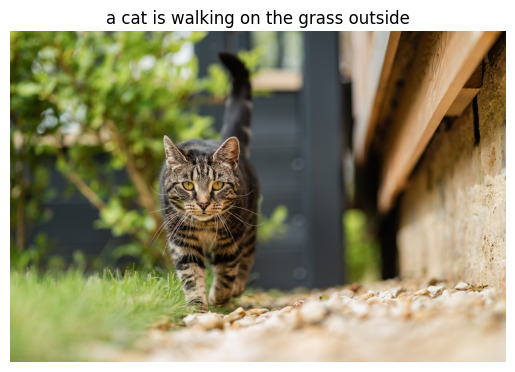

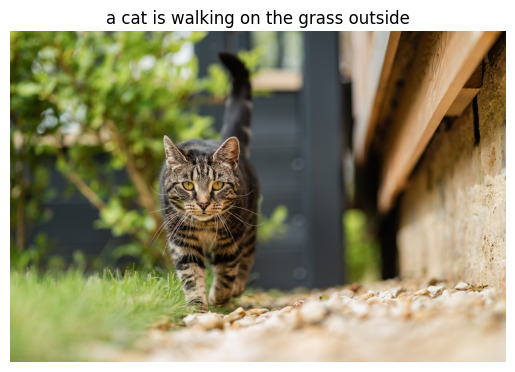

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image

model_path = "/content/drive/MyDrive/dl_final_project/saved_model"
processor = BlipProcessor.from_pretrained(model_path)
model = BlipForConditionalGeneration.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/content/drive/MyDrive/dl_final_project/cat_pic.jpg"
image = Image.open(image_path).convert("RGB")

model.eval()
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    caption = processor.decode(outputs[0], skip_special_tokens=True)

print(f"Generated Caption: {caption}")
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(caption)
plt.axis("off")
plt.show()
